In [6]:
import time
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from torch.nn import Sequential as Sq
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.autograd as autograd
import argparse


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


class SwissRoll(torch.utils.data.Dataset):
    def __init__(self, n_samples=100000, noise=0.5):
        from sklearn.datasets import make_swiss_roll
        x = make_swiss_roll(n_samples=n_samples, noise=0.5)[0][:,[0, 2]]
        xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
        x = (x - xmin) / (xmax - xmin)
        self.x = torch.FloatTensor(2. * x - 1.)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [7]:
class Score(nn.Module):
    def __init__(self, x_dim=2, hidden_dim=256):
        super().__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim

        self.net = Sq(nn.Linear(x_dim + 1, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.GroupNorm(32, hidden_dim),
                      nn.SiLU(inplace=True),
                      nn.Linear(hidden_dim, x_dim))

    def forward(self, x, t):
        return self.net(torch.cat([x, t], -1))

In [10]:
class VESDE(nn.Module):
    def __init__(self, min_std=0.001, max_std=10.00):
        super().__init__()
        self.register_buffer('min_std', torch.tensor([min_std]))
        self.register_buffer('max_std', torch.tensor([max_std]))
    
    def sample_t(self, batch_size):
        return torch.rand(batch_size)

    def g(self, t):
        return self.min_std * torch.pow((self.max_std / self.min_std), t)

    def std(self, t):
        return self.g(t)

    def marg_std(self, t):
        coeff = self.min_std / (torch.log(self.max_std / self.min_std))
        integral = coeff * (torch.pow((self.max_std / self.min_std), t) - 1)
        return self.min_std + integral


In [18]:
args = argparse.Namespace()

args.min_std = 1e-3
args.max_std = 25.0
args.learning_rate = 1e-4
args.batch_size = 256
args.num_epochs = 100


dataset = SwissRoll()
score = Score()
vesde = VESDE(min_std=args.min_std, max_std=args.max_std)
optimizer = optim.Adam(score.parameters(), lr=args.learning_rate)
loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
loss_meter = AverageMeter()

In [19]:
for epoch in range(100):
    loss_meter.reset()
    for x in loader:
        
        t = vesde.sample_t(batch_size=x.size()[0])
        t = t.unsqueeze(1)
        optimizer.zero_grad()
        marg_std = vesde.marg_std(t)
        noise = torch.randn_like(x)
        xt = x + marg_std * noise
        s = score(xt, t)
        loss = (marg_std * s + noise).square().mean(dim=0).sum()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), x.size()[0])
    print('[epoch %d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch 0] | loss: 1.78287 |
[epoch 1] | loss: 1.73715 |
[epoch 2] | loss: 1.70030 |
[epoch 3] | loss: 1.68988 |
[epoch 4] | loss: 1.68426 |
[epoch 5] | loss: 1.66867 |
[epoch 6] | loss: 1.67354 |
[epoch 7] | loss: 1.66475 |
[epoch 8] | loss: 1.65709 |
[epoch 9] | loss: 1.65639 |
[epoch 10] | loss: 1.65192 |
[epoch 11] | loss: 1.63355 |
[epoch 12] | loss: 1.62546 |
[epoch 13] | loss: 1.63641 |
[epoch 14] | loss: 1.62397 |
[epoch 15] | loss: 1.62919 |
[epoch 16] | loss: 1.62406 |
[epoch 17] | loss: 1.60972 |
[epoch 18] | loss: 1.61359 |
[epoch 19] | loss: 1.60020 |
[epoch 20] | loss: 1.60143 |
[epoch 21] | loss: 1.59286 |
[epoch 22] | loss: 1.59637 |
[epoch 23] | loss: 1.58314 |
[epoch 24] | loss: 1.59418 |
[epoch 25] | loss: 1.58627 |
[epoch 26] | loss: 1.59702 |
[epoch 27] | loss: 1.59170 |
[epoch 28] | loss: 1.57898 |
[epoch 29] | loss: 1.58277 |
[epoch 30] | loss: 1.58340 |
[epoch 31] | loss: 1.57022 |
[epoch 32] | loss: 1.57869 |
[epoch 33] | loss: 1.56653 |
[epoch 34] | loss: 1.570

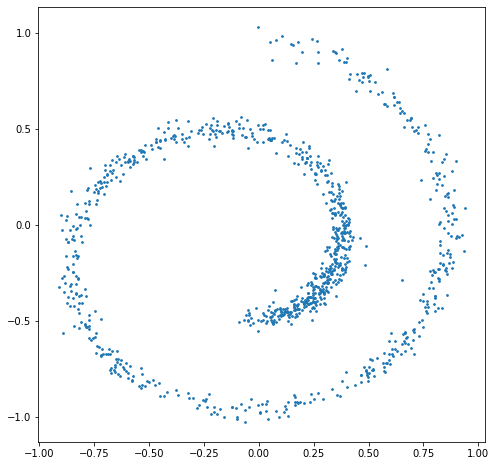

In [21]:
@torch.no_grad()

def sample_euler(sde, score, num_samples, num_steps):

    x = sde.marg_std(t=1.) * torch.randn(num_samples, 2)
    t = torch.ones(num_samples).unsqueeze(1)


    reversed_time = torch.linspace(1., 0., num_steps)
    dt = reversed_time[1] - reversed_time[0] # negative value

    for i in range(num_steps):
        t.fill_(reversed_time[i])
        g = sde.g(reversed_time[i])
        dw = dt.abs().sqrt() * torch.randn_like(x)
        dx = - (g**2) * score(x, t) * dt + g * dw
        x = x + dx
    
    return x

x = sample_euler(vesde, score, num_samples=1000, num_steps=1000)
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()

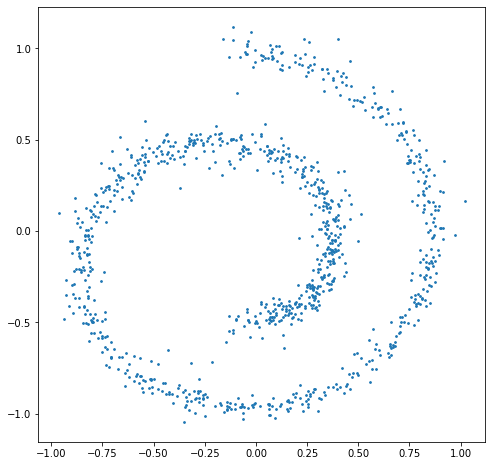

In [22]:
# discrete style sampling

def forward_sn_coeff(alp_s, std_s, alp_t, std_t): # 0 <= s < t <= 1
    falp_t = alp_t / alp_s  # q(t|s)
    fstd_t = (std_t.square() - std_s.square() * falp_t.square()).sqrt()
    return falp_t, fstd_t

def reverse_sn_coeff(alp_s, std_s, alp_t, std_t):        # q(z_s|z_t, z_0)
    falp_t, fstd_t = forward_sn_coeff(alp_s, std_s, alp_t, std_t)
    rstd_s = std_s * fstd_t / std_t
    ralp_0 = rstd_s.square() * alp_s / std_s.square()    # for z0(= signal)
    ralp_t = rstd_s.square() * falp_t / fstd_t.square()  # for zt(= noise at time t)
    return ralp_0, ralp_t, rstd_s

@torch.no_grad()
def reverse_process(vesde, z, model, num_steps):
    time = torch.ones(z.size()[0]).to(z.device)
    reversed_time = torch.linspace(1., 0., num_steps + 1)
    dt = reversed_time[0] - reversed_time[1]
    for i in range(num_steps): # t -> s
        t = reversed_time[i]        
        s = reversed_time[i + 1]

        std_s = vesde.marg_std(s).unsqueeze(1)
        std_t = vesde.marg_std(t).unsqueeze(1)
        alp_s = torch.ones_like(std_s)
        alp_t = torch.ones_like(std_t)
        ralp_0, ralp_t, rstd_s = reverse_sn_coeff(alp_s, std_s, alp_t, std_t)
        time.fill_(t)
        score = model(z, time.unsqueeze(1))
        x_pred = z + std_t.square() * score
        rloc_s = ralp_0 * x_pred + ralp_t * z
        z = rloc_s + torch.randn_like(z) * rstd_s
    return x_pred


z = vesde.marg_std(t=1.) * torch.randn(1000, 2)
x = reverse_process(vesde, z, score, 1000)
plt.figure(figsize=(8, 8))

plt.scatter(x[:, 0], x[:, 1], s=3)
plt.show()